In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]

In [2]:
iris = sklearn.datasets.load_iris()

X = pd.DataFrame(iris.data, columns=iris.feature_names)

X_zscaled = (X - X.mean()) / X.std(ddof=1)

Y = pd.DataFrame(iris.target, columns=['target'])
Y['species'] = Y.apply(lambda r: iris.target_names[r])

## Multicollinearity Check

Using $corr(X)$, check to see that we some level of multicollinearity in the data, enough to warrant using PCA of visualization in reduced-rank principal component space. As a rule of thumb, the off-diagonal correlation values (either in the upper- or lower-triangle) should have absolute values of around 0.30 or so.

In [3]:
corr = X_zscaled.corr()

tmp = pd.np.triu(corr) - np.eye(corr.shape[0]) 
tmp = tmp.flatten()
tmp = tmp[np.nonzero(tmp)]
tmp = pd.Series(np.abs(tmp))

print('Correlation matrix:\n\n{}\n\n'.format(corr.values))

print('Multicollinearity check using off-diagonal values:\n\n{}'.format(tmp.describe()))

Correlation matrix:

[[ 1.         -0.10936925  0.87175416  0.81795363]
 [-0.10936925  1.         -0.4205161  -0.35654409]
 [ 0.87175416 -0.4205161   1.          0.9627571 ]
 [ 0.81795363 -0.35654409  0.9627571   1.        ]]


Multicollinearity check using off-diagonal values:

count    6.000000
mean     0.589816
std      0.341915
min      0.109369
25%      0.372537
50%      0.619235
75%      0.858304
max      0.962757
dtype: float64


## PCA via Eigen-Decomposition

### Obtain eigenvalues, eigenvectors of $cov(X)$ via eigen-decomposition

From the factorization of symmetric matrix $S$ into orthogonal matrix $Q$ of the eigenvectors and diagonal matrix $\Lambda$ of the eigenvalues, we can likewise decompose $cov(X)$ (or in our case $corr(X)$ since we standardized our data).

\begin{align}
  S &= Q \Lambda Q^\intercal \\
  \Rightarrow X^\intercal X &= V \Lambda V^\intercal \\
\end{align}

where $V$ are the orthonormal eigenvectors of $X X^\intercal$.

We can normalize the eigenvalues to see how much variance is captured per each respective principal component. We will also calculate the cumulative variance explained. This will help inform our decision of how many principal components to keep when reducing dimensions in visualizing the data.

In [4]:
eigenvalues, eigenvectors = np.linalg.eig(X_zscaled.cov())

eigenvalues_normalized = eigenvalues / eigenvalues.sum()

cumvar_explained = np.cumsum(eigenvalues_normalized)

### Reduce dimensions and visualize

To project the original data into principal component space, we obtain score matrix $T$ by taking the dot product of $X$ and the eigenvectors $V$.

\begin{align}
  T &= X V \\
\end{align}

In [5]:
T = pd.DataFrame(X_zscaled.dot(eigenvectors))

# set column names
T.columns = ['pc1', 'pc2', 'pc3', 'pc4']

# also add the species label as 
T = pd.concat([T, Y.species], axis=1)

We can visualize the original, 4D iris data of $X$ by using the first $k$ eigenvectors of $X$, projecting the original data into a reduced-rank $k$-dimensional principal component space.

\begin{align}
  T_{rank=k} &= X V_{rank=k}
\end{align}

<IPython.core.display.Javascript object>


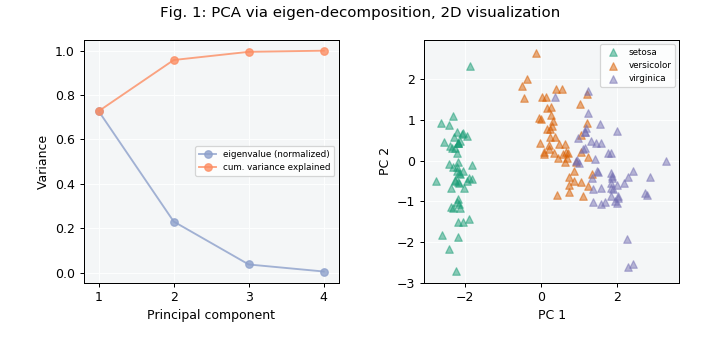

In [6]:
# let's try using the first 2 principal components
k = 2

# divide T by label
irises = [T[T.species=='setosa'], 
          T[T.species=='versicolor'], 
          T[T.species=='virginica']]

# define a color-blind friendly set of quantative colors
# for each species
colors = ['#1b9e77', '#d95f02', '#7570b3']

_, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

# plot principal component vis-a-vis total variance in data
ax1.plot([1,2,3,4],
         eigenvalues_normalized,
         '-o',
         color='#8da0cb',
         label='eigenvalue (normalized)',
         alpha=0.8,
         zorder=1000)

ax1.plot([1,2,3,4],
         cumvar_explained,
         '-o',
         color='#fc8d62',
         label='cum. variance explained',
         alpha=0.8,
         zorder=1000)

ax1.set_xlim(0.8, 4.2)
ax1.set_xticks([1,2,3,4])
ax1.set_xlabel('Principal component')
ax1.set_ylabel('Variance')
ax1.legend(loc='center right', fontsize=7)
ax1.grid(color='#fdfefe')
ax1.set_facecolor('#f4f6f7')

# plot the reduced-rank score matrix representation
for group, color in zip(irises, colors):
    ax2.scatter(group.pc1,
                group.pc2,
                marker='^',
                color=color,
                label=group.species,
                alpha=0.5,
                zorder=1000)
ax2.set_xlabel(r'PC 1')
ax2.set_ylabel(r'PC 2')
ax2.grid(color='#fdfefe')
ax2.set_facecolor('#f4f6f7')
ax2.legend(labels=iris.target_names, fontsize=7)

plt.suptitle(r'Fig. 1: PCA via eigen-decomposition, 2D visualization')
plt.tight_layout(pad=3.0)
plt.show()    

### Relative weights of the original features in principal component space

* Each row of $V$ is a vector representing the relative weights for each of the original features for each principal component.
* Given reduced-rank $k$, the columns of $V_k$ are the weights for principal components $1, \dots, k$.
* Calculate the norm for each row of $V_k$, and normalize the results to obtain the relative weights for each original feature in principal component space.

In [7]:
feature_norms = np.linalg.norm(eigenvectors[:, 0:k], axis=1)
feature_weights = feature_norms / feature_norms.sum()

msg = ('Using {} principal components, '
       'the original features are represented with the following weights:')
print(msg.format(k))
for feature, weight in zip(iris.feature_names, feature_weights):
    print('-  {}: {:0.3f}'.format(feature, weight))

Using 2 principal components, the original features are represented with the following weights:
-  sepal length (cm): 0.233
-  sepal width (cm): 0.349
-  petal length (cm): 0.211
-  petal width (cm): 0.207


## PCA via Singular Value Decomposition

Singular value decomposition factors any matrix $A$ into right-singular vector matrix $U$; diagonal matrix of singular values $\Sigma$; and right-singular vector matrix $V$.

\begin{align}
  A &= U \Sigma V^\intercal \\
\end{align}

If we start with 

\begin{align}
  X &= U \Sigma V^\intercal \\
  \\
  X^\intercal X &= (U \Sigma V^\intercal)^\intercal U \Sigma V^\intercal \\
  &= V \Sigma^\intercal U^\intercal U \Sigma V^\intercal \\
  &= V \Sigma^\intercal \Sigma V^\intercal \\
  \\
  \Rightarrow \Sigma^\intercal \Sigma &= \Lambda
\end{align}

In [8]:
U, S, Vt = np.linalg.svd(X_zscaled)

In [9]:
print(eigenvectors)

[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


In [10]:
print(Vt.T)

[[ 0.52237162 -0.37231836  0.72101681  0.26199559]
 [-0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577 -0.6338014   0.52354627]]


In [11]:
Vt.T.shape

(4, 4)